# Stochastic Coagulation-Fragmentation:
## Full derivation with Moment Closure and Code Generation
$$
\def\n{\mathbf{n}}
\def\x{\mathbf{x}}
\def\N{\mathbb{\mathbb{N}}}
\def\X{\mathbb{X}}
\def\NX{\mathbb{\N_0^\X}}
\def\C{\mathcal{C}}
\def\Jc{\mathcal{J}_c}
\def\DM{\Delta M_{c,j}}
\newcommand\diff{\mathop{}\!\mathrm{d}}
\def\Xc{\mathbf{X}_c}
\def\Yc{\mathbf{Y}_c}
\newcommand{\muset}[1]{\dot{\{}#1\dot{\}}}
$$

Here we illustrate the full treatment of another system, from model definition to code generation and simulation.

In [1]:
# Remove matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# initialize sympy printing (for latex output)
from sympy import init_printing, Symbol
init_printing()

# import functions and classes for compartment models
from compartor import *

## Specifying the model

In [3]:
x = Content('x')
y = Content('y')

# define intake distribution
pi_I = OutcomeDistribution.Poisson(Symbol("\pi_{Poiss}(y; \lambda)"), y[0], Symbol("\lambda"))
# define fragmentation distribution
pi_F = OutcomeDistribution.Uniform(Symbol("\pi_F(y|x)"), y[0], 0, x[0])

Intake        = TransitionClass( {}        -to> [y],         'k_I',         pi=pi_I, name='I')
Exit          = TransitionClass( [x]       -to> {},          'k_E',                  name='E')
Coagulation   = TransitionClass( [x] + [y] -to> [x+y],       'k_C',                  name='C')
Fragmentation = TransitionClass( [x]       -to> [y] + [x-y], 'k_F', g=x[0], pi=pi_F, name='F')

transitions = [Intake, Exit, Coagulation, Fragmentation]
display_transition_classes(transitions)

                     EmptySet ---> [y],  h_I = \pi_{Poiss}(y; \lambda)*k_I    
                               [x] ---> EmptySet,  h_E = k_E*n(x)             
[x] + [y] ---> [x + y],  h_C = k_C*(n(y) - KroneckerDelta(x, y))*n(x)/(Kroneck
                    [x] ---> [x - y] + [y],  h_F = \pi_F(y|x)*k_F*n(x)*x[0]   

                  
                  
erDelta(x, y) + 1)
                  

## Deriving the moment equations

Next we specify the moments we want to derive, for example, $N$, $N^2$, $M^1$, and $(M^1)^2$.

To denote a particular moment, use the `Moment` class. It takes as constructor arguments the integer exponents in each species.

In [4]:
moments = [
    Moment(0),
    Moment(0)**2,
    Moment(1),
    Moment(1)**2
]
display(moments)

⎡                 2                      2   ⎤
⎣Moment(0), Moment (0), Moment(1), Moment (1)⎦

### With the automated procedure

The fastest way to generate a closed system of moment equations for the desired set of moment is to call the function `automated_moment_equations()` as follows:

In [5]:
equations = automated_moment_equations(1, transitions, [Moment(0),Moment(0)**2,Moment(1),Moment(1)**2])
display_moment_equations(equations)

Computed moment equations for desired moments $\left< N\right> $, $\left< N^{2}\right> $, $\left< M^{1}\right> $, and $\left< {\left(M^{1}\right)}^{\mathtt{\text{2}}}\right> $.

Equations were iteratively added for $\left< M^{2}\right> $ and $\left< N M^{1}\right> $.

Gamma closures were substituted for $\left< M^{3}\right> $, $\left< N^{2} M^{1}\right> $, and $\left< N^{3}\right> $.

                                                         ⎛ 2⎞                 
d                    k_C⋅Expectation(N)   k_C⋅Expectation⎝N ⎠                 
──(Expectation(N)) = ────────────────── - ─────────────────── - k_E⋅Expectatio
dt                           2                     2                          

                                       
                                       
n(N) + k_F⋅Expectation(Moment(1)) + k_I
                                       

                            ⎛                                                2
d ⎛           ⎛ 2⎞⎞         ⎜                            ⎛ 2⎞   2⋅Expectation 
──⎝Expectation⎝N ⎠⎠ = - k_C⋅⎜- Expectation(N)⋅Expectation⎝N ⎠ + ──────────────
dt                          ⎝                                     Expectation(

⎛ 2⎞⎞                                         ⎛ 2⎞                            
⎝N ⎠⎟   k_C⋅Expectation(N)   3⋅k_C⋅Expectation⎝N ⎠                            
────⎟ - ────────────────── + ───────────────────── + k_E⋅Expectation(N) - 2⋅k_
N)  ⎠           2                      2                                      

                                                                              
             ⎛ 2⎞                                                             
E⋅Expectation⎝N ⎠ + 2⋅k_F⋅Expectation(N⋅Moment(1)) + k_F⋅Expectation(Moment(1)
                                                                              

                              
                  

d                                                                    
──(Expectation(Moment(1))) = \lambda⋅k_I - k_E⋅Expectation(Moment(1))
dt                                                                   

d ⎛           ⎛      2   ⎞⎞          2                                        
──⎝Expectation⎝Moment (1)⎠⎠ = \lambda ⋅k_I + 2⋅\lambda⋅k_I⋅Expectation(Moment(
dt                                                                            

                                     ⎛      2   ⎞                             
1)) + \lambda⋅k_I - 2⋅k_E⋅Expectation⎝Moment (1)⎠ + k_E⋅Expectation(Moment(2))
                                                                              

                                                                              
                                                                              
                                                                              
d                                   2                                    ⎛    
──(Expectation(Moment(2))) = \lambda ⋅k_I + \lambda⋅k_I + k_C⋅Expectation⎝Mome
dt                                                                            

                                                                        ⎛     
                                                                        ⎜2⋅Exp
                                                                    k_F⋅⎜─────
  2   ⎞                                                                 ⎝  Exp
nt (1)⎠ - k_C⋅Expectation(Moment(2)) - k_E⋅Expectation(Moment(2)) - ──────────
                                                                              

        2                                         

                                                                              
                                                                              
                                                                          k_C⋅
d                                                                             
──(Expectation(N⋅Moment(1))) = \lambda⋅k_I⋅Expectation(N) + \lambda⋅k_I - ────
dt                                                                            

⎛                                                        ⎛ 2⎞                 
⎜             ⎛ 2⎞                          2⋅Expectation⎝N ⎠⋅Expectation(N⋅Mo
⎜- Expectation⎝N ⎠⋅Expectation(Moment(1)) + ──────────────────────────────────
⎝                                                         Expectation(N)      
──────────────────────────────────────────────────────────────────────────────
                                         2                                    

        ⎞                                         

### Step-by-step

Alternatively, one can opt for a step-by-step derivation to manually control the construction of the ODE system and the application of moment closure schemes.


We call the function `compute_moment_equations()`, giving the reaction network and the desired moment expressions.

In [6]:
equations = compute_moment_equations(transitions, moments)

To display the derived equations, use the `display_moment_equations()` function.

In [7]:
display_moment_equations(equations)

                                                         ⎛ 2⎞                 
d                    k_C⋅Expectation(N)   k_C⋅Expectation⎝N ⎠                 
──(Expectation(N)) = ────────────────── - ─────────────────── - k_E⋅Expectatio
dt                           2                     2                          

                                       
                                       
n(N) + k_F⋅Expectation(Moment(1)) + k_I
                                       

                                                              ⎛ 2⎞            
d ⎛           ⎛ 2⎞⎞     k_C⋅Expectation(N)   3⋅k_C⋅Expectation⎝N ⎠            
──⎝Expectation⎝N ⎠⎠ = - ────────────────── + ───────────────────── - k_C⋅Expec
dt                              2                      2                      

                                                                              
      ⎛ 3⎞                                         ⎛ 2⎞                       
tation⎝N ⎠ + k_E⋅Expectation(N) - 2⋅k_E⋅Expectation⎝N ⎠ + 2⋅k_F⋅Expectation(N⋅
                                                                              

                                                                    
                                                                    
Moment(1)) + k_F⋅Expectation(Moment(1)) + 2⋅k_I⋅Expectation(N) + k_I
                                                                    

d                                                                    
──(Expectation(Moment(1))) = \lambda⋅k_I - k_E⋅Expectation(Moment(1))
dt                                                                   

d ⎛           ⎛      2   ⎞⎞          2                                        
──⎝Expectation⎝Moment (1)⎠⎠ = \lambda ⋅k_I + 2⋅\lambda⋅k_I⋅Expectation(Moment(
dt                                                                            

                                     ⎛      2   ⎞                             
1)) + \lambda⋅k_I - 2⋅k_E⋅Expectation⎝Moment (1)⎠ + k_E⋅Expectation(Moment(2))
                                                                              

**The system is not closed!** Moment equations are missing for:

⎧                           3              ⎫
⎨Moment(0)⋅Moment(1), Moment (0), Moment(2)⎬
⎩                                          ⎭

The `display_moment_equations()` function also notifies us that the system is not closed, and which moments are missing. (This output can be suppressed by passing the optional second argument `display_moment_equations(equations, print_missing=False)`).

These "missing" moments are moment expressions whose expectations occur on the right-hand side of equations but which are not governed by the system. They can also be computed using the `get_missing_moments()` function.

In [8]:
missing = get_missing_moments(equations)
missing

⎧                           3              ⎫
⎨Moment(0)⋅Moment(1), Moment (0), Moment(2)⎬
⎩                                          ⎭

We add the moments below order 3 to the list of moments to derive and iterate the derivation. (We apply gamma closure for 3rd order moments below.)

In [9]:
moments = [
    Moment(0),
    Moment(0)**2,
    Moment(1),
    Moment(1)**2,
    Moment(0)*Moment(1),
    Moment(2)
]
display(moments)

⎡                 2                      2                                   ⎤
⎣Moment(0), Moment (0), Moment(1), Moment (1), Moment(0)⋅Moment(1), Moment(2)⎦

In [10]:
equations = compute_moment_equations(transitions, moments)
display_moment_equations(equations)

                                                         ⎛ 2⎞                 
d                    k_C⋅Expectation(N)   k_C⋅Expectation⎝N ⎠                 
──(Expectation(N)) = ────────────────── - ─────────────────── - k_E⋅Expectatio
dt                           2                     2                          

                                       
                                       
n(N) + k_F⋅Expectation(Moment(1)) + k_I
                                       

                                                              ⎛ 2⎞            
d ⎛           ⎛ 2⎞⎞     k_C⋅Expectation(N)   3⋅k_C⋅Expectation⎝N ⎠            
──⎝Expectation⎝N ⎠⎠ = - ────────────────── + ───────────────────── - k_C⋅Expec
dt                              2                      2                      

                                                                              
      ⎛ 3⎞                                         ⎛ 2⎞                       
tation⎝N ⎠ + k_E⋅Expectation(N) - 2⋅k_E⋅Expectation⎝N ⎠ + 2⋅k_F⋅Expectation(N⋅
                                                                              

                                                                    
                                                                    
Moment(1)) + k_F⋅Expectation(Moment(1)) + 2⋅k_I⋅Expectation(N) + k_I
                                                                    

d                                                                    
──(Expectation(Moment(1))) = \lambda⋅k_I - k_E⋅Expectation(Moment(1))
dt                                                                   

d ⎛           ⎛      2   ⎞⎞          2                                        
──⎝Expectation⎝Moment (1)⎠⎠ = \lambda ⋅k_I + 2⋅\lambda⋅k_I⋅Expectation(Moment(
dt                                                                            

                                     ⎛      2   ⎞                             
1)) + \lambda⋅k_I - 2⋅k_E⋅Expectation⎝Moment (1)⎠ + k_E⋅Expectation(Moment(2))
                                                                              

                                                                              
d                                                                         k_C⋅
──(Expectation(N⋅Moment(1))) = \lambda⋅k_I⋅Expectation(N) + \lambda⋅k_I + ────
dt                                                                            

                                          ⎛ 2          ⎞                      
Expectation(N⋅Moment(1))   k_C⋅Expectation⎝N ⋅Moment(1)⎠                      
──────────────────────── - ───────────────────────────── - 2⋅k_E⋅Expectation(N
         2                               2                                    

                                                                              
                                                          ⎛      2   ⎞        
⋅Moment(1)) + k_E⋅Expectation(Moment(1)) + k_F⋅Expectation⎝Moment (1)⎠ + k_I⋅E
                                                                              

                     
                     
xpect

d                                   2                                    ⎛    
──(Expectation(Moment(2))) = \lambda ⋅k_I + \lambda⋅k_I + k_C⋅Expectation⎝Mome
dt                                                                            

  2   ⎞                                                             k_F⋅Expect
nt (1)⎠ - k_C⋅Expectation(Moment(2)) - k_E⋅Expectation(Moment(2)) + ──────────
                                                                              

ation(Moment(2))   k_F⋅Expectation(Moment(3))
──────────────── - ──────────────────────────
  3                            3             

**The system is not closed!** Moment equations are missing for:

⎧      2                     3              ⎫
⎨Moment (0)⋅Moment(1), Moment (0), Moment(3)⎬
⎩                                           ⎭

## Gamma closure
Next we compute the Gamma closures for the missing moments.

In [11]:
missing = get_missing_moments(equations)
closures = gamma_closures(missing)
display_closures(closures)

                                      2                                       
                         2⋅Expectation (Moment(2))   Expectation(Moment(1))⋅Ex
Expectation(Moment(3)) = ───────────────────────── - ─────────────────────────
                           Expectation(Moment(1))                    Expectati

                    
pectation(Moment(2))
────────────────────
on(N)               

                                                                              
           ⎛ 2          ⎞                ⎛ 2⎞                          2⋅Expec
Expectation⎝N ⋅Moment(1)⎠ = - Expectation⎝N ⎠⋅Expectation(Moment(1)) + ───────
                                                                              

      ⎛ 2⎞                         
tation⎝N ⎠⋅Expectation(N⋅Moment(1))
───────────────────────────────────
       Expectation(N)              

                                                                  2⎛ 2⎞
           ⎛ 3⎞                               ⎛ 2⎞   2⋅Expectation ⎝N ⎠
Expectation⎝N ⎠ = - Expectation(N)⋅Expectation⎝N ⎠ + ──────────────────
                                                       Expectation(N)  

Currently, only Gamma closure for 3rd order moments is implemented.
If the closure for an expression can not be computed, the function raises an error.
Alternatively, a list can be supplied as second argument `gamma_closures(expressions, could_not_close)`, and the expressions that could not be closed will be added there (instead or raising an error).

In this example, all of the `missing` expression could be closed, so...

In [12]:
could_not_close=[]
closures = gamma_closures(missing, could_not_close)
could_not_close

We substitute the closures into the moment equations.

In [13]:
equations = substitute_closures(equations, closures)
display_moment_equations(equations)

                                                         ⎛ 2⎞                 
d                    k_C⋅Expectation(N)   k_C⋅Expectation⎝N ⎠                 
──(Expectation(N)) = ────────────────── - ─────────────────── - k_E⋅Expectatio
dt                           2                     2                          

                                       
                                       
n(N) + k_F⋅Expectation(Moment(1)) + k_I
                                       

                            ⎛                                                2
d ⎛           ⎛ 2⎞⎞         ⎜                            ⎛ 2⎞   2⋅Expectation 
──⎝Expectation⎝N ⎠⎠ = - k_C⋅⎜- Expectation(N)⋅Expectation⎝N ⎠ + ──────────────
dt                          ⎝                                     Expectation(

⎛ 2⎞⎞                                         ⎛ 2⎞                            
⎝N ⎠⎟   k_C⋅Expectation(N)   3⋅k_C⋅Expectation⎝N ⎠                            
────⎟ - ────────────────── + ───────────────────── + k_E⋅Expectation(N) - 2⋅k_
N)  ⎠           2                      2                                      

                                                                              
             ⎛ 2⎞                                                             
E⋅Expectation⎝N ⎠ + 2⋅k_F⋅Expectation(N⋅Moment(1)) + k_F⋅Expectation(Moment(1)
                                                                              

                              
                  

d                                                                    
──(Expectation(Moment(1))) = \lambda⋅k_I - k_E⋅Expectation(Moment(1))
dt                                                                   

d ⎛           ⎛      2   ⎞⎞          2                                        
──⎝Expectation⎝Moment (1)⎠⎠ = \lambda ⋅k_I + 2⋅\lambda⋅k_I⋅Expectation(Moment(
dt                                                                            

                                     ⎛      2   ⎞                             
1)) + \lambda⋅k_I - 2⋅k_E⋅Expectation⎝Moment (1)⎠ + k_E⋅Expectation(Moment(2))
                                                                              

                                                                              
                                                                              
                                                                          k_C⋅
d                                                                             
──(Expectation(N⋅Moment(1))) = \lambda⋅k_I⋅Expectation(N) + \lambda⋅k_I - ────
dt                                                                            

⎛                                                        ⎛ 2⎞                 
⎜             ⎛ 2⎞                          2⋅Expectation⎝N ⎠⋅Expectation(N⋅Mo
⎜- Expectation⎝N ⎠⋅Expectation(Moment(1)) + ──────────────────────────────────
⎝                                                         Expectation(N)      
──────────────────────────────────────────────────────────────────────────────
                                         2                                    

        ⎞                                         

                                                                              
                                                                              
                                                                              
d                                   2                                    ⎛    
──(Expectation(Moment(2))) = \lambda ⋅k_I + \lambda⋅k_I + k_C⋅Expectation⎝Mome
dt                                                                            

                                                                        ⎛     
                                                                        ⎜2⋅Exp
                                                                    k_F⋅⎜─────
  2   ⎞                                                                 ⎝  Exp
nt (1)⎠ - k_C⋅Expectation(Moment(2)) - k_E⋅Expectation(Moment(2)) - ──────────
                                                                              

        2                                         

## Code generation
From the closed equations, we can generate code for simulating the system.
Currently, Python or Julia code can be generated.
Both derive from a common `AbstractCodeGenerator` class, and it should be relatively straightforward to tweak the code generation for other languages/solvers.

Here, we use the Python generator.

In [14]:
generator = GeneratePython()
code = generator.generate(equations, function_name="coagulation_fragmentation")
exec(code) 

This creates code for two functions, `coagulation_fragmentation_ODEs` and `coagulation_fragmentation_initial`.
The arguments to the functions are listed in the doc strings:

In [15]:
help(coagulation_fragmentation_initial)
help(coagulation_fragmentation_ODEs)

Help on function coagulation_fragmentation_initial in module __main__:

coagulation_fragmentation_initial(initial)
    Create inital expected moments vector
    
    :param initial: tuple of initial values for expectations of (Moment(0,), Moment(1,), Moment(2,))
    :return: initial expected moments vector

Help on function coagulation_fragmentation_ODEs in module __main__:

coagulation_fragmentation_ODEs(M, dM, parameters)
    Evaluate derivatives of expected moments
    
    Indices in M and dM vectors are 
      M[0] = Moment(0,)
      M[1] = Moment(0)**2
      M[2] = Moment(1,)
      M[3] = Moment(1)**2
      M[4] = Moment(0)*Moment(1)
      M[5] = Moment(2,)
    
    :param M: expected moments
    :param dM: result, the derivative dM/dt is stored here
    :param parameters: tuple of values for constants (\lambda, k_C, k_E, k_F, k_I)
    :return: dM



## Solving and plotting results
We use the generated functions with `scipy.solve_ivp` to solve the system.

In [16]:
from scipy.integrate import solve_ivp
import numpy as np

# vector of timepoints where to solve ODE problem
timepoints = np.linspace(0, 100, 1001)

# initial condition
# 100 compartments with 10 molecules each
M0 = coagulation_fragmentation_initial((100, 1000, 10000))

# rate constants and other parameters
kC = 0.005
kF = 0.005
kI = 10.0
kE = 0.1
Lambda = 50
parameters = (Lambda, kC, kE, kF, kI)

# solve
sol = solve_ivp(
    lambda t, M: coagulation_fragmentation_ODEs(M, np.zeros(6), parameters),
    (np.min(timepoints), np.max(timepoints)),
    M0,
    method='BDF',
    t_eval=timepoints)

# print solution of N
print(sol.y[0])

[100.          98.09964031  96.31871186 ... 100.04489169 100.04479285
 100.04470542]


Finally, we use `matplotlib` to plot the solution for mean and standard deviation of $N$.

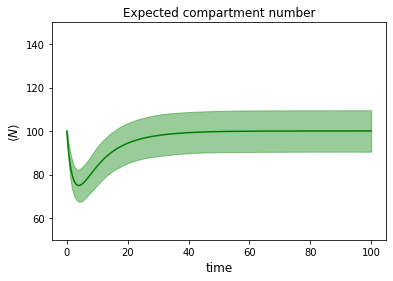

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

y = sol.y
N = y[0]
stdN = np.sqrt(y[1] - N**2)
plt.plot(timepoints, y[0], color="g")
plt.ylabel(r'$\left< N \right>$', size=12)
plt.xlabel('time', size=12)
plt.title("Expected compartment number", size=12)
plt.fill_between(timepoints, N-stdN, N+stdN, alpha=0.4, color="g")
plt.ylim((50,150))